In [1]:
import sys
import os
current_dir = os.getcwd()  
project_root = os.path.dirname(current_dir)  
sys.path.insert(0, project_root) 
from pathlib import Path
import warnings
import pandas as pd
import numpy as np
from pycaret.regression import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFE, mutual_info_regression
from src.config.config import Config
from src.data.data_loader import DataLoader
from src.models.model_evaluator import ModelEvaluator

def train_models(train: pd.DataFrame,val: pd.DataFrame,target_column: str):
    """训练模型流程
    Args:
        data_path: 可选的数据文件路径
    """
    model_evaluator.setup_experiment(
        train_size=Config.MODEL_CONFIG['train_size'],
        train_data=train,
        val_data = val,
        target_column = target_column,
        categorical_features = Config.FEATURE_CONFIG['categorical_columns']
    )

    # 训练模型并返回最佳模型字典
    return model_evaluator.train_top_models(n_models=Config.MODEL_CONFIG['n_top_models'])

def tune(models: dict):
    """模型调优和集成"""
    # 对top模型进行调优
    tuned_models = model_evaluator.tune_models(models)

    return tuned_models

def ensemble(models: dict):
    """模型集成"""
    # 对top模型进行集成
    blended_model = model_evaluator.ensemble_models(models)

    return blended_model    
    # 模型
    
def save_models(models: dict):

    model_evaluator.saved_models(models)

def select_features(train_data: pd.DataFrame, test_data: pd.DataFrame, 
                   time_test_data: pd.DataFrame, n_features: int = 15) -> tuple:
    """选择最重要的特征
    
    Args:
        train_data: 训练数据
        test_data: 测试数据
        time_test_data: 时间测试数据
        n_features: 要选择的特征数量，默认为15
        
    Returns:
        tuple: (处理后的训练集, 测试集, 时间测试集)
    """
    # 排除不需要的列
    target_transformed = f"{Config.DATA_CONFIG['target_column']}_{Config.FEATURE_CONFIG['target_transform_method']}"
    feature_cols = [col for col in train_data.columns 
                    if col not in [Config.DATA_CONFIG['target_column'], target_transformed,
                                 'Country Name', 'Year', 'Region', 'Income Group']]
    
    # 自动调整特征数量，确保不超过样本量的1/10
    sample_count = len(train_data)
    max_features = min(n_features, sample_count // 10)
    if max_features < n_features:
        print(f"警告: 样本量({sample_count})较小，特征数量已从{n_features}自动调整为{max_features}")
        n_features = max_features
    
    # 准备数据
    X = train_data[feature_cols]
    y = train_data[target_transformed]
    
    # 1. 基于模型的特征选择 (SelectFromModel)
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    selector1 = SelectFromModel(rf_model, threshold='median')
    selector1.fit(X, y)
    model_selected_features = X.columns[selector1.get_support()].tolist()
    
    # 计算特征重要性分数
    rf_model.fit(X, y)
    model_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # 2. 递归特征消除 (RFE)
    rfe_selector = RFE(estimator=RandomForestRegressor(n_estimators=50, random_state=42), 
                      n_features_to_select=n_features, step=1)
    rfe_selector.fit(X, y)
    rfe_selected_features = X.columns[rfe_selector.support_].tolist()
    
    # 计算RFE排名
    rfe_ranking = pd.DataFrame({
        'feature': feature_cols,
        'ranking': rfe_selector.ranking_
    }).sort_values('ranking')
    
    # 3. 基于互信息的特征选择 (mutual_info_regression)
    mi_scores = mutual_info_regression(X, y)
    mi_selected_features = pd.DataFrame({
        'feature': feature_cols,
        'mi_score': mi_scores
    }).sort_values('mi_score', ascending=False).head(n_features)['feature'].tolist()
    
    # 4. 添加LASSO特征选择 (适合小样本量)
    from sklearn.linear_model import LassoCV
    lasso = LassoCV(cv=5, random_state=42, max_iter=2000)
    lasso.fit(X, y)
    lasso_importance = np.abs(lasso.coef_)
    lasso_selected_features = pd.DataFrame({
        'feature': feature_cols,
        'importance': lasso_importance
    }).sort_values('importance', ascending=False).head(n_features)['feature'].tolist()
    
    # 统计每个特征被选中的次数（投票）
    feature_votes = {}
    for feature in feature_cols:
        feature_votes[feature] = 0
        if feature in model_selected_features:
            feature_votes[feature] += 1
        if feature in rfe_selected_features:
            feature_votes[feature] += 1
        if feature in mi_selected_features:
            feature_votes[feature] += 1
        if feature in lasso_selected_features:
            feature_votes[feature] += 1
    
    # 按投票数排序选择特征
    selected_features = pd.DataFrame({
        'feature': list(feature_votes.keys()),
        'votes': list(feature_votes.values())
    }).sort_values(['votes', 'feature'], ascending=[False, True]).head(n_features)['feature'].tolist()
    
    # 打印各方法选择的特征
    print("\n基于模型重要性选择的特征:")
    for i, row in model_importance.head(10).iterrows():
        print(f"{i+1}. {row['feature']} (重要性: {row['importance']:.4f})")
        
    print("\n基于递归特征消除选择的特征:")
    for i, feature in enumerate(rfe_selected_features[:10], 1):
        print(f"{i}. {feature} (排名: {rfe_ranking[rfe_ranking['feature']==feature]['ranking'].values[0]})")
        
    print("\n基于互信息选择的特征:")
    for i, feature in enumerate(mi_selected_features[:10], 1):
        mi_value = mi_scores[feature_cols.index(feature)]
        print(f"{i}. {feature} (互信息: {mi_value:.4f})")
        
    print("\n基于LASSO选择的特征:")
    for i, feature in enumerate(lasso_selected_features[:10], 1):
        lasso_value = lasso_importance[feature_cols.index(feature)]
        print(f"{i}. {feature} (LASSO系数: {lasso_value:.4f})")
    
    # 打印最终选择的特征
    print(f"\n最终选择的{len(selected_features)}个特征 (基于投票):")
    for i, feature in enumerate(selected_features, 1):
        votes = feature_votes[feature]
        print(f"{i}. {feature} (得票: {votes}/4)")
    
    # 更新数据集，保留目标变量和转换后的目标变量
    selected_columns = selected_features + [target_transformed]    
    train = train_data[selected_columns]
    test = test_data[selected_columns]
    time_test = time_test_data[selected_columns]
    
    return train, test, time_test

In [2]:
# 示例用法
df = pd.read_csv(Path(Config.PATH_CONFIG['features_dir'])  / 'training_data.csv')
data_loader = DataLoader()
model_evaluator = ModelEvaluator()

# 划分数据集
train_data, val_data, country_test_data = data_loader.split_data_by_countries(
    df,
    train_size=Config.DATA_CONFIG['country_train_size'],
    val_size=Config.DATA_CONFIG['country_val_size'],
    random_state=Config.DATA_CONFIG['random_state']
)

train_data, time_test_data = data_loader.split_data_by_time(train_data,
    test_size=Config.DATA_CONFIG['time_test_size'])

# 数据分析
print('\n训练集统计信息:')
data_loader.analyze_datasets(train_data)
print('\n验证集统计信息:')
data_loader.analyze_datasets(val_data)
print('\n外部国家测试集统计信息:')
data_loader.analyze_datasets(country_test_data)
print('\n外部时间测试集统计信息:')
data_loader.analyze_datasets(time_test_data)
#合并验证集和外部国家测试集作为测试集
test_data = pd.concat([val_data, country_test_data])
print('\n合并，作为测试集统计信息:')
data_loader.analyze_datasets(test_data)

train_data.to_csv(os.path.join(Config.PATH_CONFIG['data_dir'], 'train.csv'), index=False)
test_data.to_csv(os.path.join(Config.PATH_CONFIG['data_dir'], 'test.csv'), index=False)
time_test_data.to_csv(os.path.join(Config.PATH_CONFIG['data_dir'], 'time_test_data.csv'), index=False)


训练集统计信息:
总数据条数: 1311
国家总数: 57
包含的国家: Albania, Algeria, Argentina, Austria, Belgium, Bosnia and Herzegovina, Brazil, Bulgaria, Colombia, Congo, Dem. Rep., Croatia, Cyprus, Czechia, Denmark, Egypt, Arab Rep., Ethiopia, Finland, France, Germany, Greece, Hungary, India, Indonesia, Iran, Islamic Rep., Iraq, Ireland, Italy, Korea, Rep., Latvia, Lithuania, Luxembourg, Malaysia, Malta, Mexico, Montenegro, Morocco, Nigeria, North Macedonia, Norway, Pakistan, Poland, Portugal, Romania, Russian Federation, Serbia, Slovak Republic, Slovenia, South Africa, Spain, Sweden, Switzerland, Tanzania, Turkiye, Uganda, Ukraine, United Kingdom, United States

特征数量: 56
特征列表: 0_population_relative_gdp_pc, 1_population_relative_gdp_pc, 2_population_relative_gdp_pc, MSW, MSW_log, consumption_capacity, consumption_growth, decade, development_population_interaction, development_stage_consumption, early_development_stage, economic_development_level, ekc_distance, gdp_pc_population_interaction, gdp_population_inter

In [3]:
# 排除不需要的列
feature_cols = [col for col in train_data.columns 
                if col not in [Config.DATA_CONFIG['target_column'], 'Country Name', 'Year','Region', 'Income Group']]

train = train_data[feature_cols]
test = test_data[feature_cols]
time_test_data = time_test_data[feature_cols] 

target_column = Config.DATA_CONFIG['target_column']
method = Config.FEATURE_CONFIG['target_transform_method']
transformed_column = f'{target_column}_{method}'

In [4]:
# 使用特征选择方法
selected_features, test_selected, time_test_selected = select_features(train_data, test_data, time_test_data, n_features=10)

# 强制添加时间相关特征
time_features = [col for col in train_data.columns if any(term in col for term in 
                ['year', 'time', 'decade', 'country_specific', 'growth_from_first', 'acceleration'])]

for col in time_features:
    if col not in selected_features.columns:
        selected_features[col] = train_data[col]
        test_selected[col] = test_data[col]
        time_test_selected[col] = time_test_data[col]
        print(f"强制添加时间特征: {col}")

# 使用增强后的特征集训练模型
train, test, time_test_data = selected_features, test_selected, time_test_selected


基于模型重要性选择的特征:
42. gdp_population_interaction (重要性: 0.9165)
24. income_group_population_rank (重要性: 0.0069)
17. population_squared (重要性: 0.0059)
19. population_exp (重要性: 0.0059)
25. income_group_gdp_rank (重要性: 0.0056)
27. region_population_rank (重要性: 0.0056)
55. population_consumption_efficiency (重要性: 0.0047)
18. population_cubic (重要性: 0.0045)
4. gdp_ppp_2017_log (重要性: 0.0043)
7. gdp_ppp_2017_exp (重要性: 0.0043)

基于递归特征消除选择的特征:
1. Population (排名: 1)
2. gdp_ppp_2017_squared (排名: 1)
3. gdp_ppp_2017_cubic (排名: 1)
4. population_cubic (排名: 1)
5. population_exp (排名: 1)
6. income_group_population_rank (排名: 1)
7. income_group_gdp_rank (排名: 1)
8. region_population_rank (排名: 1)
9. gdp_population_interaction (排名: 1)
10. population_consumption_efficiency (排名: 1)

基于互信息选择的特征:
1. gdp_population_interaction (互信息: 2.2823)
2. population_log (互信息: 2.2778)
3. population_squared (互信息: 2.2750)
4. population_exp (互信息: 2.2734)
5. population_cubic (互信息: 2.2695)
6. income_group_population_rank (互信息: 2.1095)
7. po

In [5]:
# 训练模型
models = train_models(train,test,transformed_column)

,Description,Value
0,Session id,456
1,Target,MSW_log
2,Target type,Regression
3,Original data shape,"(1682, 14)"
4,Transformed data shape,"(1682, 14)"
5,Transformed train set shape,"(1311, 14)"
6,Transformed test set shape,"(371, 14)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.3017,0.1503,0.3703,0.9194,0.0221,0.0194,0.5980
br,Bayesian Ridge,0.3131,0.1662,0.3970,0.9128,0.0233,0.0198,0.0060
huber,Huber Regressor,0.3358,0.1962,0.4301,0.8980,0.0253,0.0212,0.0120
ridge,Ridge Regression,0.3313,0.2237,0.4548,0.8874,0.0264,0.0211,0.6420
gbr,Gradient Boosting Regressor,0.3501,0.2145,0.4555,0.8836,0.0269,0.0222,0.0660
rf,Random Forest Regressor,0.3688,0.2283,0.4726,0.8725,0.0280,0.0235,0.0440
xgboost,Extreme Gradient Boosting,0.3922,0.2491,0.4892,0.8620,0.0287,0.0248,0.0820
et,Extra Trees Regressor,0.3806,0.2697,0.5075,0.8519,0.0297,0.0241,0.0280
ada,AdaBoost Regressor,0.3945,0.2689,0.5075,0.8544,0.0303,0.0252,0.0260
lightgbm,Light Gradient Boosting Machine,0.3939,0.2663,0.5097,0.8533,0.0302,0.0250,0.0900


In [6]:
# 定义需要包含的模型简称集合
include_models = {'rf','xgboost','et','lightgbm','gbr','catboost','knn'}

# 生成过滤后的有序字典
model_dict = {
    k: v for k, v in models.items()
    if k in include_models
}

In [7]:
print(f'当前调优模型: {", ".join(model_dict.keys())}')

# 调优
tune_models = tune(model_dict)

当前调优模型: gbr, rf, xgboost, et, lightgbm
当前调优模型: gbr , 结果如下:


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4138,0.2642,0.5140,0.8632,0.0321,0.0274
1,0.3574,0.3006,0.5483,0.8566,0.0300,0.0211
2,0.3408,0.1590,0.3987,0.9433,0.0259,0.0238
3,0.3368,0.1561,0.3950,0.8854,0.0238,0.0217
4,0.2593,0.1045,0.3232,0.9303,0.0180,0.0153
Mean,0.3416,0.1969,0.4359,0.8958,0.0260,0.0218
Std,0.0495,0.0734,0.0830,0.0351,0.0050,0.0040


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.3534,0.2130,0.4616,0.9288,0.0273,0.0223


当前调优模型: rf , 结果如下:


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5105,0.3499,0.5915,0.8188,0.0371,0.0338
1,0.3904,0.3042,0.5515,0.8549,0.0305,0.0233
2,0.3128,0.1458,0.3818,0.9480,0.0252,0.0220
3,0.2948,0.1223,0.3497,0.9102,0.0211,0.0190
4,0.3135,0.1799,0.4242,0.8800,0.0228,0.0182
Mean,0.3644,0.2204,0.4597,0.8824,0.0273,0.0232
Std,0.0802,0.0901,0.0951,0.0444,0.0058,0.0056


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.3726,0.2364,0.4862,0.9210,0.0287,0.0234


当前调优模型: xgboost , 结果如下:


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4162,0.2590,0.5089,0.8659,0.0306,0.0268
1,0.2928,0.1759,0.4194,0.9161,0.0228,0.0172
2,0.3231,0.1450,0.3807,0.9483,0.0249,0.0226
3,0.3188,0.1454,0.3813,0.8932,0.0230,0.0206
4,0.3143,0.1673,0.4091,0.8884,0.0222,0.0184
Mean,0.3330,0.1785,0.4199,0.9024,0.0247,0.0211
Std,0.0429,0.0420,0.0470,0.0279,0.0031,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.3197,0.1892,0.4349,0.9368,0.0258,0.0203


当前调优模型: et , 结果如下:


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5242,0.3940,0.6277,0.7960,0.0385,0.0343
1,0.3702,0.2696,0.5192,0.8714,0.0283,0.0219
2,0.3239,0.1620,0.4025,0.9422,0.0269,0.0230
3,0.2912,0.1190,0.3450,0.9126,0.0207,0.0187
4,0.3399,0.2523,0.5022,0.8318,0.0268,0.0196
Mean,0.3699,0.2394,0.4793,0.8708,0.0282,0.0235
Std,0.0812,0.0954,0.0981,0.0528,0.0057,0.0056


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.3978,0.2854,0.5342,0.9047,0.0317,0.0252


当前调优模型: lightgbm , 结果如下:


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3822,0.2389,0.4887,0.8763,0.0303,0.0253
1,0.3410,0.2931,0.5414,0.8602,0.0294,0.0201
2,0.3146,0.1419,0.3766,0.9494,0.0251,0.0223
3,0.3815,0.2110,0.4593,0.8450,0.0275,0.0245
4,0.2544,0.0911,0.3018,0.9393,0.0173,0.0153
Mean,0.3347,0.1952,0.4336,0.8940,0.0259,0.0215
Std,0.0476,0.0713,0.0848,0.0424,0.0047,0.0036


[LightGBM] [Warning] feature_fraction is set=0.5180017465115141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5180017465115141
[LightGBM] [Warning] bagging_fraction is set=0.8271244670666464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8271244670666464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.3440,0.2186,0.4675,0.9270,0.0280,0.0220


[LightGBM] [Warning] feature_fraction is set=0.5180017465115141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5180017465115141
[LightGBM] [Warning] bagging_fraction is set=0.8271244670666464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8271244670666464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [8]:
# 集成
models = ensemble(tune_models)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4255,0.2769,0.5262,0.8567,0.0326,0.0280
1,0.3303,0.2506,0.5006,0.8804,0.0272,0.0195
2,0.3034,0.1389,0.3727,0.9504,0.0248,0.0215
3,0.3188,0.1390,0.3728,0.8979,0.0225,0.0205
4,0.2822,0.1386,0.3723,0.9076,0.0201,0.0165
Mean,0.3320,0.1888,0.4289,0.8986,0.0254,0.0212
Std,0.0494,0.0618,0.0695,0.0312,0.0043,0.0038


[LightGBM] [Warning] feature_fraction is set=0.5180017465115141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5180017465115141
[LightGBM] [Warning] bagging_fraction is set=0.8271244670666464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8271244670666464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
2,Extreme Gradient Boosting,0.3330,0.1785,0.4199,0.9024,0.0247,0.0211,0.3920
5,Voting Regressor,0.3320,0.1888,0.4289,0.8986,0.0254,0.0212,0.1480
0,Gradient Boosting Regressor,0.3416,0.1969,0.4359,0.8958,0.0260,0.0218,0.4440
4,Light Gradient Boosting Machine,0.3347,0.1952,0.4336,0.8940,0.0259,0.0215,0.0780
1,Random Forest Regressor,0.3644,0.2204,0.4597,0.8824,0.0273,0.0232,0.4200
3,Extra Trees Regressor,0.3699,0.2394,0.4793,0.8708,0.0282,0.0235,0.0160



------------------------------
正在分析模型: GBR
------------------------------
gbr 不支持SHAP分析

------------------------------
正在分析模型: RF
------------------------------


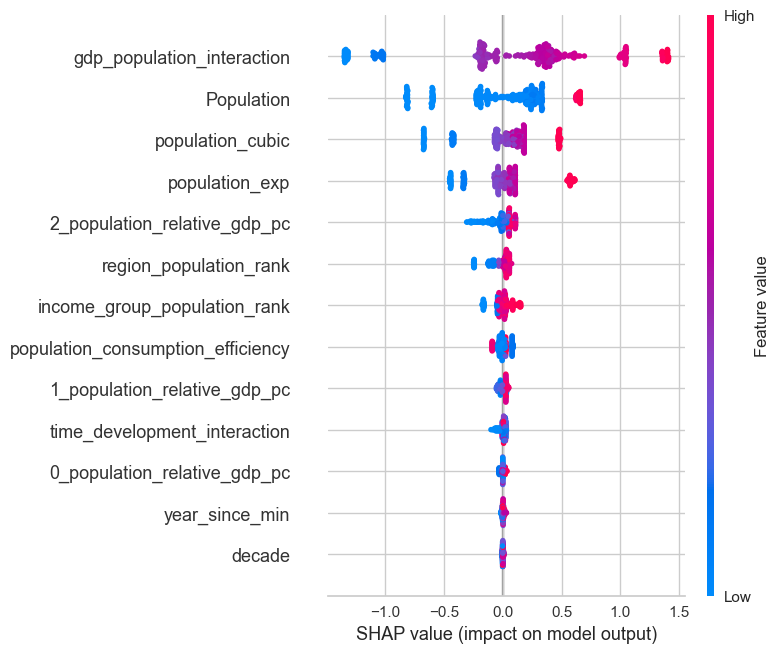

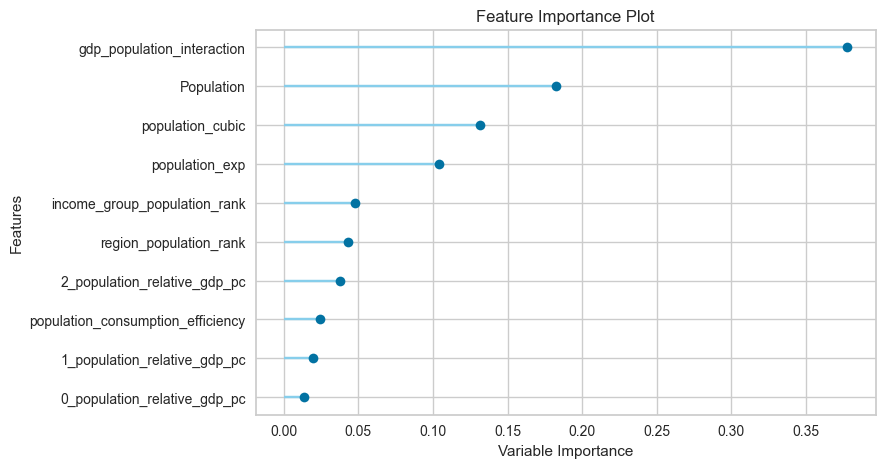


------------------------------
正在分析模型: XGBOOST
------------------------------


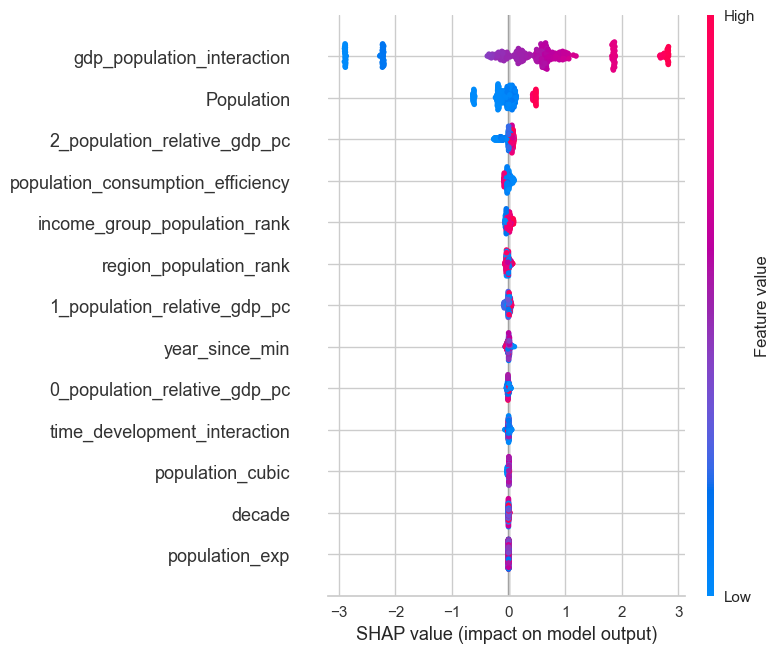

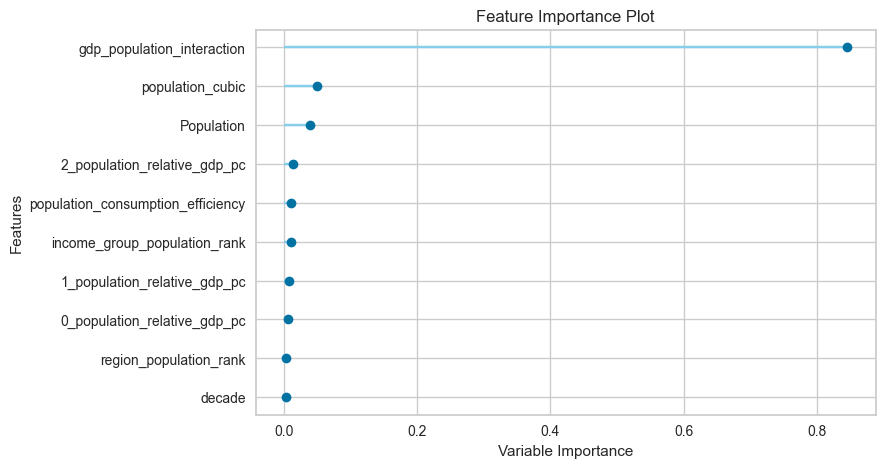


------------------------------
正在分析模型: ET
------------------------------


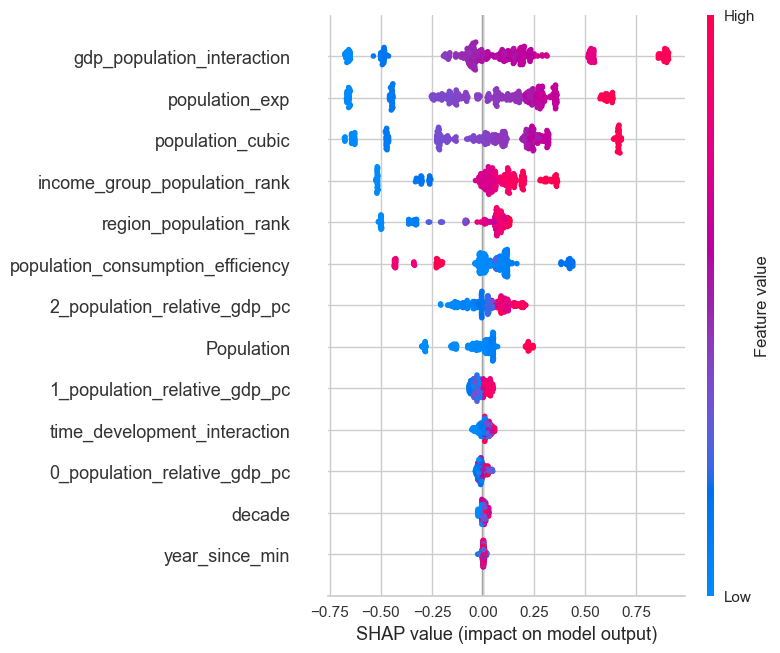

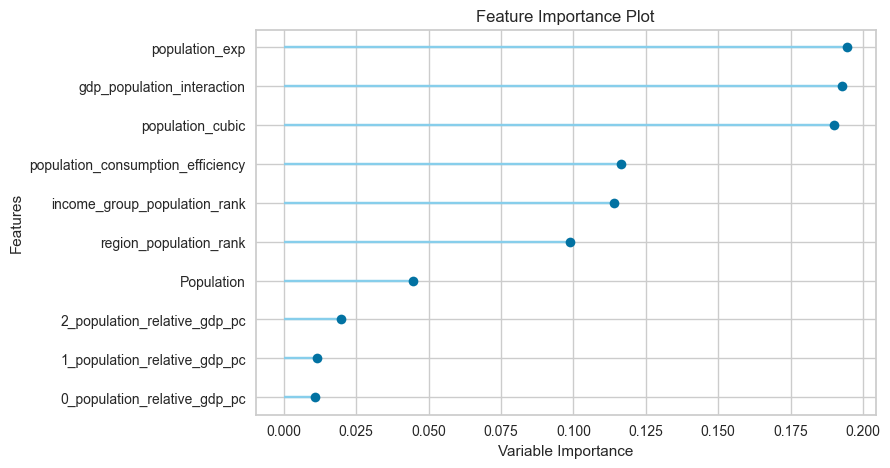


------------------------------
正在分析模型: LIGHTGBM
------------------------------


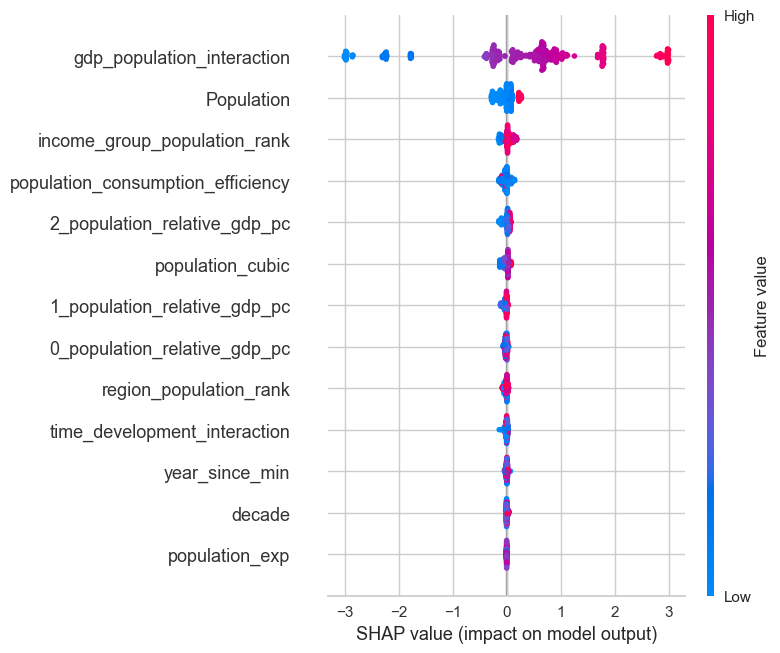

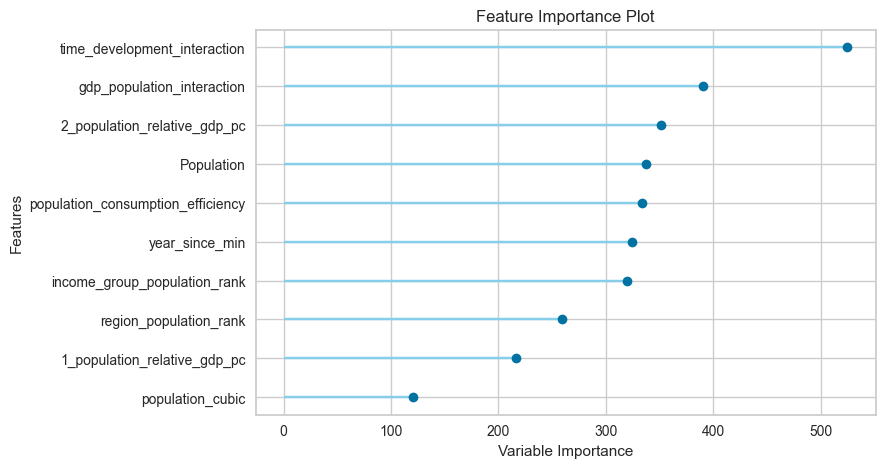


------------------------------
正在分析模型: BLEND
------------------------------
blend 不支持SHAP分析


In [9]:
for model_name, model in models.items():
    print(f"\n{'-'*30}")
    print(f"正在分析模型: {model_name.upper()}")
    print(f"{'-'*30}")
    
    # SHAP值解释（需要安装shap包）
    try:
        interpret_model(model)
        plot_model(model, plot = 'feature')
    except:
        print(f"{model_name} 不支持SHAP分析")

In [10]:
# 定义需要包含的模型简称集合
include_models = {'xgboost','et','lightgbm','gbr','catboost'}

# 生成过滤后的有序字典
seleced_model_dict = {
    k: v for k, v in tune_models.items()
    if k in include_models
}
# 集成
seleced_models = ensemble(seleced_model_dict)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4068,0.2656,0.5153,0.8625,0.0318,0.0268
1,0.3160,0.2411,0.4910,0.8850,0.0266,0.0185
2,0.3038,0.1389,0.3726,0.9505,0.0248,0.0215
3,0.3250,0.1460,0.3822,0.8927,0.0231,0.0210
4,0.2773,0.1302,0.3608,0.9132,0.0196,0.0162
Mean,0.3258,0.1843,0.4244,0.9008,0.0252,0.0208
Std,0.0436,0.0571,0.0651,0.0297,0.0040,0.0035


[LightGBM] [Warning] feature_fraction is set=0.5180017465115141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5180017465115141
[LightGBM] [Warning] bagging_fraction is set=0.8271244670666464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8271244670666464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
1,Extreme Gradient Boosting,0.3330,0.1785,0.4199,0.9024,0.0247,0.0211,0.0360
4,Voting Regressor,0.3258,0.1843,0.4244,0.9008,0.0252,0.0208,0.1080
0,Gradient Boosting Regressor,0.3416,0.1969,0.4359,0.8958,0.0260,0.0218,0.0200
3,Light Gradient Boosting Machine,0.3347,0.1952,0.4336,0.8940,0.0259,0.0215,0.0840
2,Extra Trees Regressor,0.3699,0.2394,0.4793,0.8708,0.0282,0.0235,0.0180


In [11]:
save_model = save_models(seleced_models)

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
